<a href="https://colab.research.google.com/github/cr2551/stroke_prediction/blob/main/grid_Search_N_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import kagglehub

# Import dataset
df = kagglehub.dataset_load(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    #"unsdsn/world-happiness/versions/1",
    "fedesoriano/stroke-prediction-dataset",
    "healthcare-dataset-stroke-data.csv",
)

# drop unnecessary column
df = df.drop("id", axis = 1)

Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.


# Making a Pipeline for standardization

We can prevent common mistakes by using a pipeline to handle standardization for us.


https://scikit-learn.org/stable/common_pitfalls.html

In [ ]:
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


SEED = 0

# This pipeline setup will allow us to have a pipeline
# with steps like the following: (impute, scale, SMOTENC, OneHotEncoder, model)

# categorical and numerical columns
num_cols = ["age","avg_glucose_level", "bmi"]
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_features = cat_cols  + ["hypertension", "heart_disease"]


# Define column transformers inside a pipeline
# Impute bmi with the mean and then standardize all numeric features
numerical_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())



# First ColumnTransformer: Apply numerical transformations, pass through categorical
# the numerical features will be at the beginning of the array after this transformation
# (the first few cols [0, 1, 2 ])
numerical_preprocessor = ColumnTransformer(
    transformers=[
        ("num_imputer", numerical_transformer, num_cols),
    ],
    remainder="passthrough", # Keep categorical columns as they are
    force_int_remainder_cols=False
)


# # Get all columns that are NOT numerical (these are the passthrough ones)
# passthrough_cols_in_x_train = [col for col in x_train.columns if col not in num_cols]


# from the end of the numerical array to the end of all the columns : [3, 4, 5, 6, 7, 8, 9]
cat_indices = list(range(len(num_cols), len(num_cols) + len(categorical_features)))

# Second ColumnTransformer: Apply OneHotEncoder to categorical features
# This transformer will receive the output of SMOTENC, which is a numpy array.
# The numerical features are at the beginning, categorical features are at the end.
# So the indices for OneHotEncoder are the same as cat_indices_for_smotenc.
categorical_onehot_encoder = ColumnTransformer(
    transformers=[
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), cat_indices),
    ],
    remainder="passthrough"
)



In [ ]:
# train test split
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, train_size=0.8, stratify=df.stroke, random_state=SEED)

x_train = train.drop("stroke", axis = 1)
x_test = test.drop("stroke", axis = 1)

y_train = train.stroke
y_test = test.stroke

In [ ]:
# define necessary imports
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mutual_info_score, \
  accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold


# function to evaluate several metrics using cross validation
def evaluate_cv(estimator, x_train, y_train, scoring = ["accuracy", "recall", "balanced_accuracy", "precision", "f1"]):
  cv_results = cross_validate(estimator, x_train, y_train, scoring=scoring, cv=StratifiedKFold())
  # print average of tests
  for k in cv_results.keys():
    if k.startswith("test"):
      avg = np.mean(cv_results[k])
      print(f"average {k}: {avg:.4f}")

def build_pipeline(model, undersampler = None, oversampler = None):
  # Define default overampler
  if oversampler is None:
    oversampler = SMOTENC(categorical_features=cat_indices, random_state=SEED, sampling_strategy=0.1)
  # Default undersampler
  if undersampler is None:
    undersampler = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
  # Build the imblearn pipeline

  steps= [
      ("num_preprocess", numerical_preprocessor),

      ("smotenc", oversampler),
      ("undersampler", undersampler),
      ("cat_onehot", categorical_onehot_encoder),
      ("model", model)
  ]

  pipeline = imbpipe(steps = steps)
  return pipeline



## Logistic Regression Model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {"model__C": list(np.linspace(1e-4, 1e5, 5)), "model__solver": ["lbfgs", "liblinear", "sag"],
              "model__penalty": [ "l2"],
              "model__class_weight": [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]}

pipeline = build_pipeline(LogisticRegression(max_iter=10000))

clf = GridSearchCV(pipeline, param_grid, scoring="f1")
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('num_preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num_imputer',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi'])])),
                                       ('smotenc',
                                        SMOTENC(categorical_features=[3, 4, 5,
                                                                      6, 7, 8,
                                                                      9],
                                                random_st...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          7, 8,
                                                                          9])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'model__C': [np.float64(0.0001),
                                      np.float64(25000.000075),
                                      np.float64(50000.000049999995),
                                      np.float64(75000.000025),
                                      np.float64(100000.0)],
                         'model__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3},
                                                 {0: 1, 1: 4}],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'liblinear', 'sag']},
             scoring='f1')

In [ ]:

lr = clf.best_estimator_.named_steps['model']
lr_pipe = build_pipeline(lr)
evaluate_cv(lr_pipe, x_train, y_train)

# performance of various tests on cross validation for Logistic Regression

average test_accuracy: 0.7353
average test_recall: 0.7837
average test_balanced_accuracy: 0.7583
average test_precision: 0.1306
average test_f1: 0.2239


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier()
forest_pipe = build_pipeline(m)
evaluate_cv(forest_pipe, x_train, y_train)
# performance of various tests on cross validation for Random Forest

average test_accuracy: 0.8444
average test_recall: 0.5176
average test_balanced_accuracy: 0.6894
average test_precision: 0.1600
average test_f1: 0.2442


# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# fit models on all of the training data
lr_pipe.fit(x_train, y_train)
forest_pipe.fit(x_train, y_train)


# we need the raw probabilities without thresholding
proba_logreg = lr_pipe.predict_proba(x_test)[:, 1]
proba_rf = forest_pipe.predict_proba(x_test)[:, 1]

# Threhold range
thresholds = [i / 10 for i in range(11)]

# compute false positive rates and tru positive rates
def compute_fpr_tpr(probas, thresholds):
  fprs, tprs = [], []
  for thr in thresholds:
    preds = (probas >= thr).astype(int)
    tn_, fp_, fn_, tp_ = confusion_matrix(y_test, preds, labels=[0, 1]).ravel()

    # compute rates
    fpr = fp_ / (fp_ + tn_) if (fp_ + tn_) else 0.0
    tpr = tp_ / (tp_ + fn_) if (tp_ + fn_) else 0.0

    fprs.append(fpr)
    tprs.append(tpr)
  return fprs, tprs




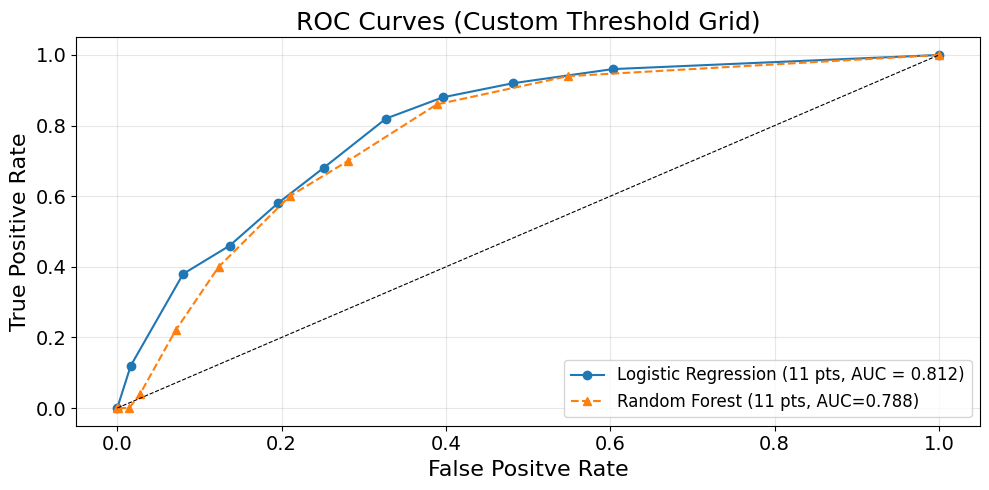

In [ ]:
fprs_logreg, tprs_logreg = compute_fpr_tpr(proba_logreg, thresholds)
fprs_rf, tprs_rf = compute_fpr_tpr(proba_rf, thresholds)

# Full ROC for true AUC (not limited to 11 points)

fpr_l_full, tpr_l_full, _ = roc_curve(y_test, proba_logreg)
fpr_rf_full, tpr_rf_full, _ = roc_curve(y_test, proba_rf)

# auc
auc_logreg = auc(fpr_l_full, tpr_l_full)
auc_rf = auc(fpr_rf_full, tpr_rf_full)

plt.figure(figsize = (10, 5))
# plot logreg
plt.plot(fprs_logreg, tprs_logreg, marker = 'o',
         label = f'Logistic Regression (11 pts, AUC = {auc_logreg:.3f})')
# plot rf individual points
plt.plot(fprs_rf, tprs_rf, marker = '^', linestyle='--',
         label=f'Random Forest (11 pts, AUC={auc_rf:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.8)
plt.xlabel('False Positve Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('ROC Curves (Custom Threshold Grid)', fontsize = 18)
plt.legend(fontsize = 12, loc = 'best')
plt.gca().tick_params(axis = 'both', labelsize = 14)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

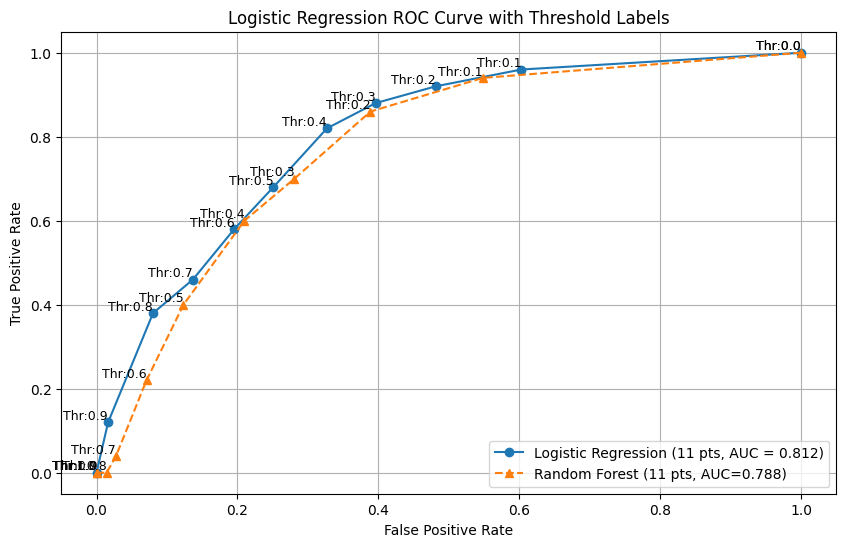

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fprs_logreg, tprs_logreg, marker='o', linestyle='-', label= f'Logistic Regression (11 pts, AUC = {auc_logreg:.3f})')

plt.plot(fprs_rf, tprs_rf, marker = '^', linestyle='--',
         label=f'Random Forest (11 pts, AUC={auc_rf:.3f})')
for i, txt in enumerate(thresholds):
    plt.text(fprs_logreg[i], tprs_logreg[i], f'Thr:{txt:.1f}', fontsize=9, ha='right', va='bottom')

for i, txt in enumerate(thresholds):
  plt.text(fprs_rf[i], tprs_rf[i], f'Thr:{txt:.1f}', fontsize=9, ha='right', va='bottom')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve with Threshold Labels')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Evaluated on Test Data

we can do random forest with threshold >=0.3 to predict positive

In [ ]:
# Random Forest
preds_rf = (proba_rf >= 0.3).astype(int)
confusion_matrix(y_test, preds)


array([[699, 273],
       [ 15,  35]])

In [ ]:
# Random Forest
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.11      0.70      0.20        50

    accuracy                           0.72      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.94      0.72      0.80      1022



Text(0.5, 1.0, 'Random Forest Confusion Matrix')

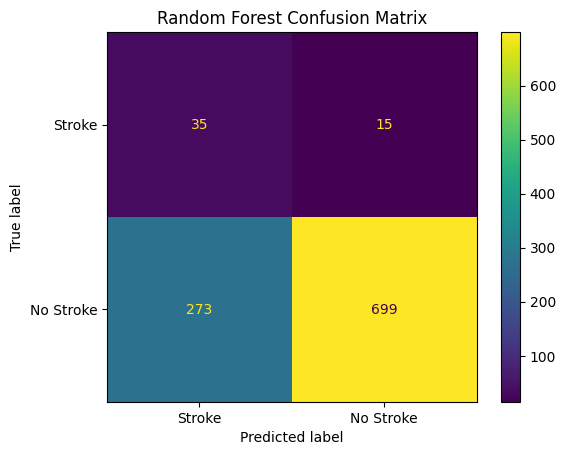

In [ ]:
# Random Forest Confuson Matrix
r_class_labels = list(reversed(class_labels))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds_rf,
                                               display_labels=r_class_labels,
                                               labels=[1, 0],
                                               cmap = "viridis")
plt.title("Random Forest Confusion Matrix")

# Logistic Regression Evaluated on Test Data

In [ ]:
# logistic regression
lr_preds = (proba_logreg >= 0.4).astype(int)
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.11      0.82      0.20        50

    accuracy                           0.68      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.94      0.68      0.77      1022



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

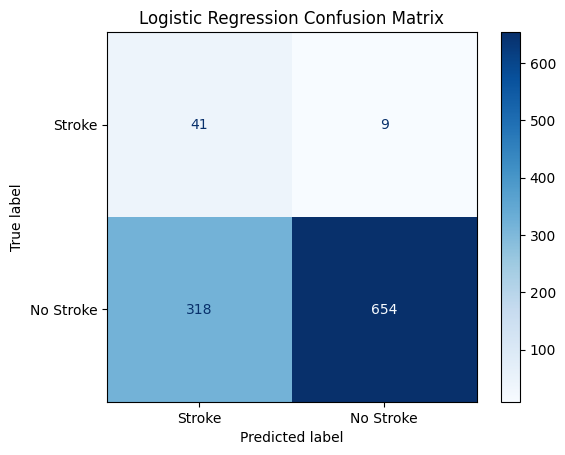

In [ ]:
# Logistic Regression Confuson Matrix

disp = ConfusionMatrixDisplay.from_predictions(y_test, lr_preds,
                                               display_labels=r_class_labels,
                                               labels=[1, 0],
                                               cmap = "Blues")
plt.title("Logistic Regression Confusion Matrix")

# Precision Recall Curve

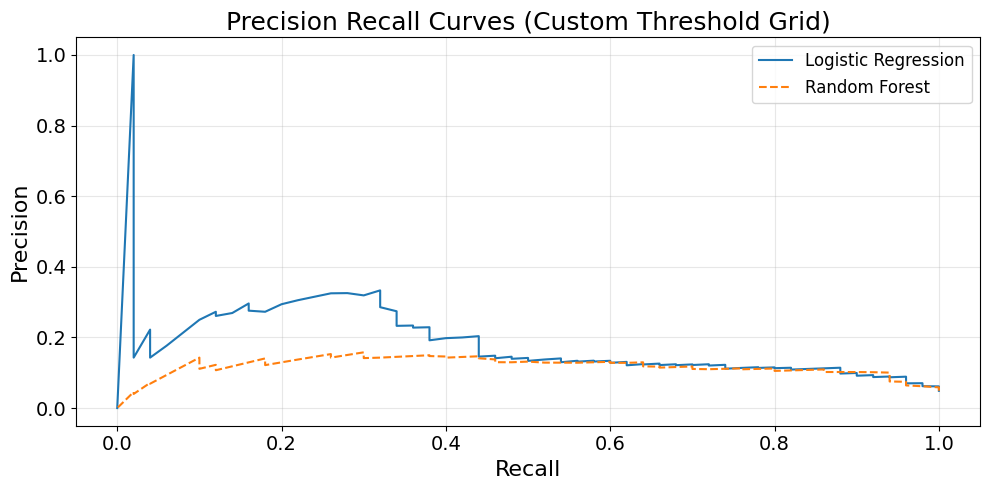

In [ ]:
# Threhold range
thresholds = [i / 300 for i in range(301)]

# compute precision and recall
def compute_pr_rc(probas, thresholds):
  fprs, tprs = [], []
  for thr in thresholds:
    preds = (probas >= thr).astype(int)
    tn_, fp_, fn_, tp_ = confusion_matrix(y_test, preds, labels=[0, 1]).ravel()

    # compute rates
    fpr = tp_ / (tp_ + fp_) if (tp_ + fp_) else 0.0
    tpr = tp_ / (tp_ + fn_) if (tp_ + fn_) else 0.0

    fprs.append(fpr)
    tprs.append(tpr)
  return fprs, tprs

# precision and recall scores for logreg
pr_logreg, rc_logreg = compute_pr_rc(proba_logreg, thresholds)
# precision and recall scores for random forest
pr_rf, rc_rf = compute_pr_rc(proba_rf, thresholds)



plt.figure(figsize = (10, 5))
# plot logreg
plt.plot(rc_logreg, pr_logreg,
         label = f'Logistic Regression')
# plot rf individual points
plt.plot(rc_rf, pr_rf , linestyle='--',
         label=f'Random Forest ')
# where is the baseline now?
#plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.8)
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.title('Precision Recall Curves (Custom Threshold Grid)', fontsize = 18)
plt.legend(fontsize = 12, loc = 'best')
plt.gca().tick_params(axis = 'both', labelsize = 14)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# SVM and PCA

In [ ]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipe

# Create a pipeline for numerical preprocessing and SMOTENC
# This partial pipeline handles the oversampling, producing the y_transformed
smotenc_pipeline_steps = [
    ("num_preprocess", numerical_preprocessor),
    ("cat", categorical_onehot_encoder),

]
pca_pipe = Pipeline(steps=smotenc_pipeline_steps)



data = pca_pipe.fit_transform(train)
# Finally, apply PCA to the fully preprocessed features
pca_model = PCA(n_components=2)
a = pca_model.fit_transform(data)

In [ ]:
class_labels = ["No Stroke", "Stroke"]

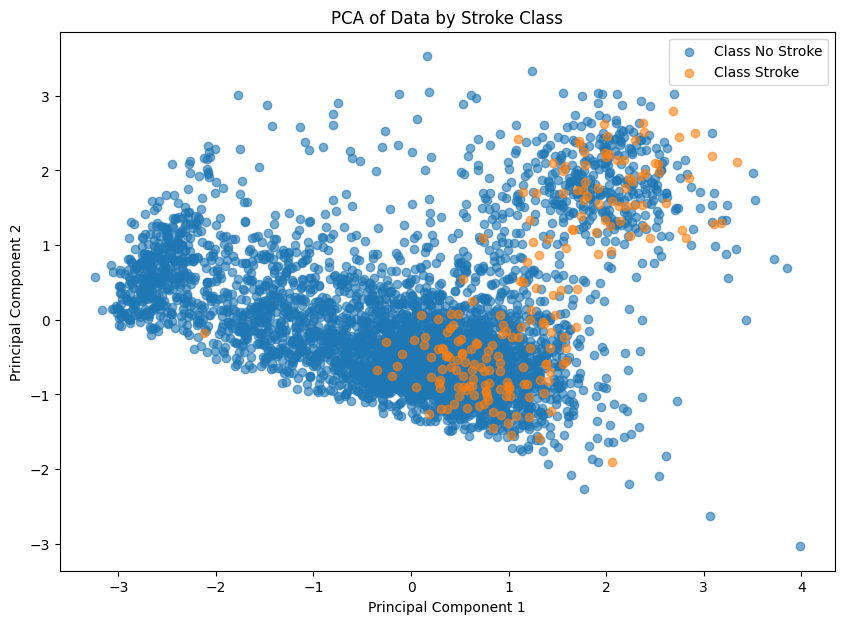

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# get unique classes and their labels
unique_classes = [0, 1]



# plot each class separately to create a legend
for class_ in unique_classes:
    # slect data points belonging to the current class
    mask = (y_train == class_)
    plt.scatter(a[mask, 0],
                a[mask, 1],
                label=f'Class {class_labels[class_]}',
                alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Data by Stroke Class')
plt.legend()
plt.show()

In [ ]:
pca_model.explained_variance_

array([1.82350911, 0.90105014])

## SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(C=10)

pipe = build_pipeline(svm)

evaluate_cv(pipe, x_train, y_train)

average test_accuracy: 0.8143
average test_recall: 0.4519
average test_balanced_accuracy: 0.6424
average test_precision: 0.1213
average test_f1: 0.1911


# Sources

https://scikit-learn.org/stable/common_pitfalls.html